In [1]:
%matplotlib inline


=============================================================================
Manifold learning Tutorial
=============================================================================

An illustration of various embeddings produced by manifold learing algorithms on the MNIST digits and S-curve datasets. See also http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html

The idea behind manifold learning is to find a feature map $\Phi : X \rightarrow F$ into a feature space $F$ with a *lower* dimension then X. This is useful when dealing with high dimensional data such as images. The map $\Phi$ should preserve a notion of intrinsic distance. More on that in the lecture.


## Some helper functions for plotting and kernel computation

In [2]:
# Authors: Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
#          Ralf Banisch
# License: BSD 3 clause (C) INRIA 2011

print(__doc__)
from time import time

import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors as neigh_search
import scipy.sparse as sps
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

#----------------------------------------------------------------------
def compute_kernel(X, epsilon):
    m = np.shape(X)[0];
    cutoff = np.sqrt(3*epsilon);

    #calling nearest neighbor search class: returning a (sparse) distance matrix
    albero = neigh_search.radius_neighbors_graph(X, radius = cutoff, mode='distance', p=2, include_self=None)

    # computing the diffusion kernel value at the non zero matrix entries
    diffusion_kernel = np.exp(-(np.array(albero.data)**2)/(epsilon))

    # build sparse matrix for diffusion kernel
    kernel = sps.csr_matrix((diffusion_kernel, albero.indices, albero.indptr), dtype = float, shape=(m,m))
    kernel = kernel + sps.identity(m)  # accounting for diagonal elements
    
    return kernel;

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(16,6))
    ax = plt.subplot(121)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)




Automatically created module for IPython interactive environment


# Visualize the datasets

Computing random projection


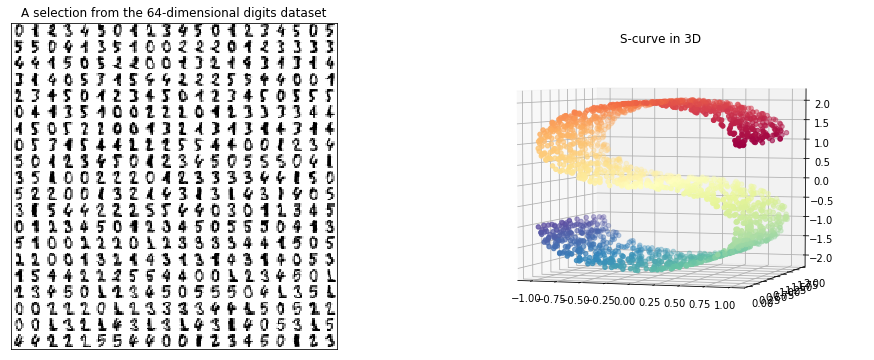

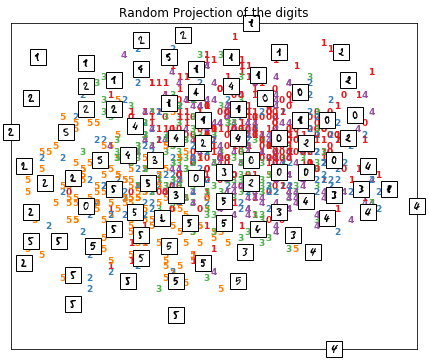

In [3]:
#----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.figure(figsize=(16, 6))
ax = plt.subplot(121)
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

#---------------------------------------------------------------------
# S-curve dataset
from mpl_toolkits.mplot3d import Axes3D

n_points = 2000
S_curve, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)

#fig = plt.figure(figsize=(6, 8))
#plt.suptitle("S-curve in 3D", fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = plt.subplot(122, projection='3d')
    plt.title('S-curve in 3D')
    ax.scatter(S_curve[:, 0], S_curve[:, 1], S_curve[:, 2], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(111, projection='3d')
    plt.scatter(S_curve[:, 0], S_curve[:, 2], c=color, cmap=plt.cm.Spectral)


#----------------------------------------------------------------------
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=89)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")

# PCA (Principal component analysis)

Computing PCA projection


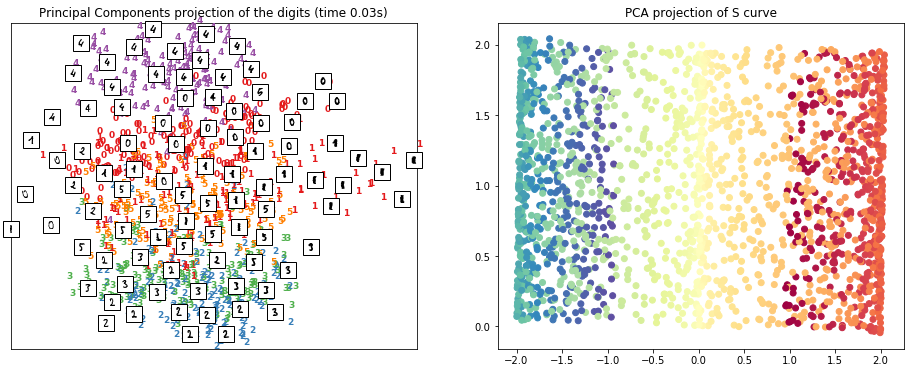

In [4]:
#----------------------------------------------------------------------
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

S_embedding = decomposition.TruncatedSVD(n_components=2).fit_transform(S_curve);

ax = plt.subplot(122);
plt.scatter(S_embedding[:,0],S_embedding[:,1], c=color, cmap=plt.cm.Spectral);
plt.title('PCA projection of S curve');
plt.axis('tight');

# MDS (Multidimensional scaling)

Computing MDS embedding
Done. Stress: 140123651.805324


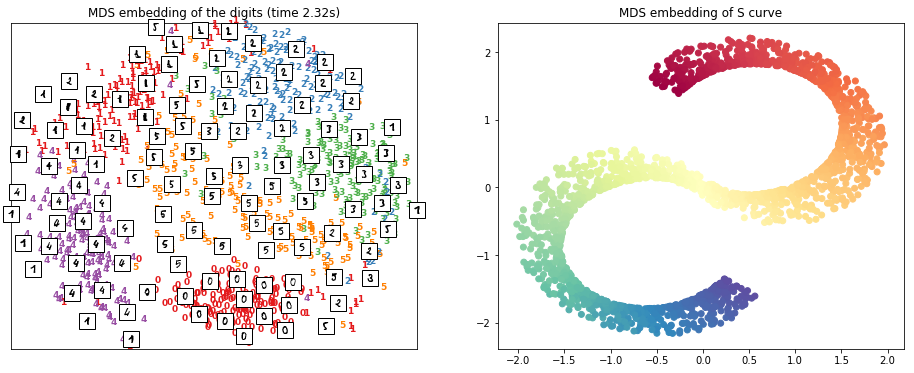

In [5]:
#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

S_embedding = manifold.MDS(n_components=2, n_init=1, max_iter=100).fit_transform(S_curve);

ax = plt.subplot(122);
plt.scatter(S_embedding[:,0],S_embedding[:,1], c=color, cmap=plt.cm.Spectral);
plt.title('MDS embedding of S curve');
plt.axis('tight');

# Isomap

Computing Isomap embedding
Done.


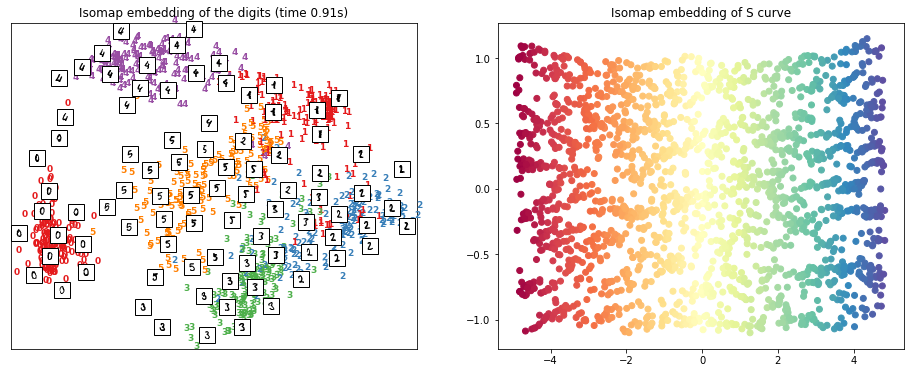

In [6]:
#----------------------------------------------------------------------
# Isomap projection of the digits dataset
print("Computing Isomap embedding")
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap embedding of the digits (time %.2fs)" %
               (time() - t0))

S_embedding = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(S_curve);

ax = plt.subplot(122);
plt.scatter(S_embedding[:,0],S_embedding[:,1], c=color, cmap=plt.cm.Spectral);
plt.title('Isomap embedding of S curve');
plt.axis('tight');

# Laplacian Eigenmaps

In [7]:
#build the kernels
kernel = compute_kernel(X,epsilon=400.0)
kernel_S = compute_kernel(S_curve, epsilon=0.25)

In [8]:
#np.shape(kernel)
m = np.shape(X)[0];
print 1./(m*m)*kernel.nnz
print 1./(n_points*n_points)*kernel_S.nnz

SyntaxError: invalid syntax (<ipython-input-8-f6ccd991eb20>, line 3)

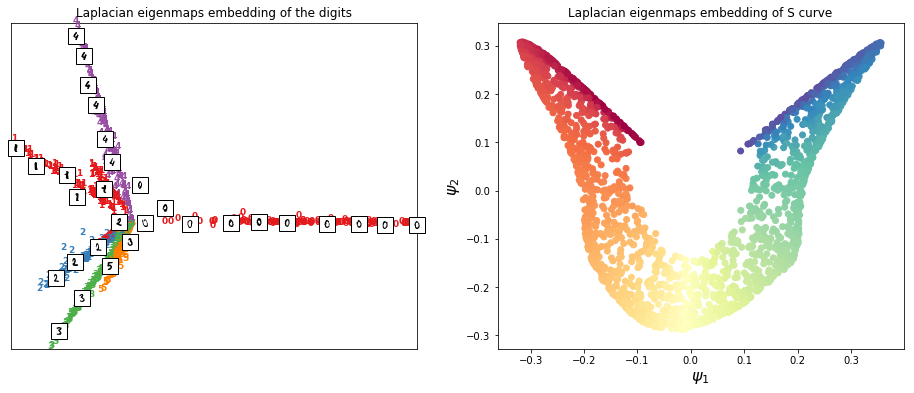

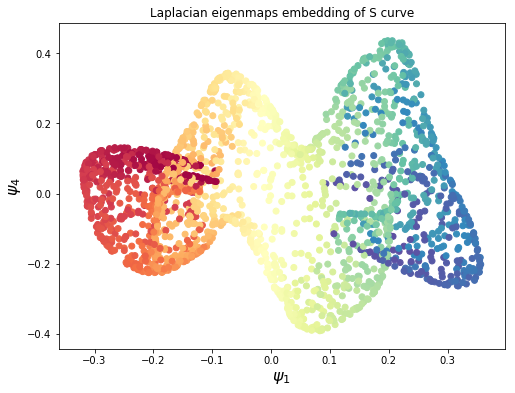

In [9]:
X_se = manifold.spectral_embedding(kernel, n_components = 2, eigen_solver = 'arpack')
plot_embedding(X_se, "Laplacian eigenmaps embedding of the digits")

S_embedding = manifold.spectral_embedding(kernel_S, n_components=5, eigen_solver = 'arpack')
ax = plt.subplot(122);
plt.scatter(S_embedding[:,0],S_embedding[:,1], c=color, cmap=plt.cm.Spectral);
plt.title('Laplacian eigenmaps embedding of S curve');
plt.xlabel('$\psi_1$',fontsize=16)
plt.ylabel('$\psi_2$',fontsize=16)
plt.axis('tight');

plt.figure(figsize=(8,6))
ax = plt.subplot(111);
plt.scatter(S_embedding[:,0],S_embedding[:,4], c=color, cmap=plt.cm.Spectral);
plt.title('Laplacian eigenmaps embedding of S curve');
plt.axis('tight');
plt.xlabel('$\psi_1$',fontsize=16)
plt.ylabel('$\psi_4$',fontsize=16)

# Diffusion Maps

In [10]:
#diffusion maps - choose alpha parameter
alpha = 1.0;
m = np.shape(X)[0];
D = sps.csr_matrix.sum(kernel, axis=0);
Dalpha = sps.spdiags(np.power(D,-alpha), 0, m, m)
kernel = Dalpha * kernel * Dalpha;

D = sps.csr_matrix.sum(kernel_S, axis=0);
Dalpha = sps.spdiags(np.power(D,-alpha), 0, n_points, n_points)
kernel_S = Dalpha * kernel_S * Dalpha;

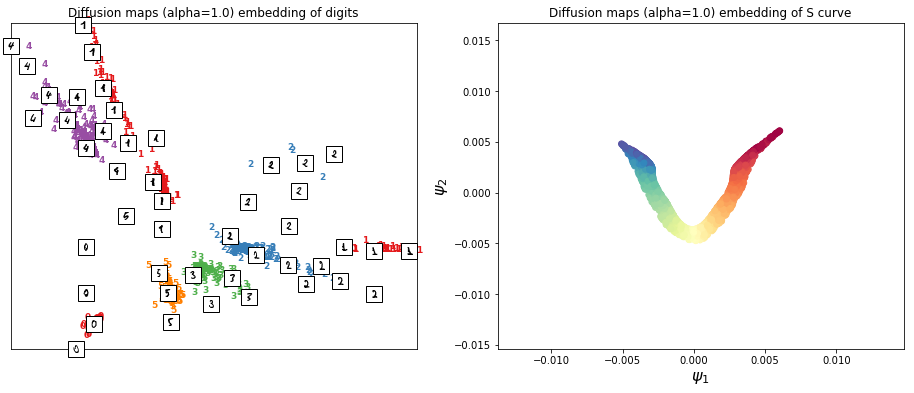

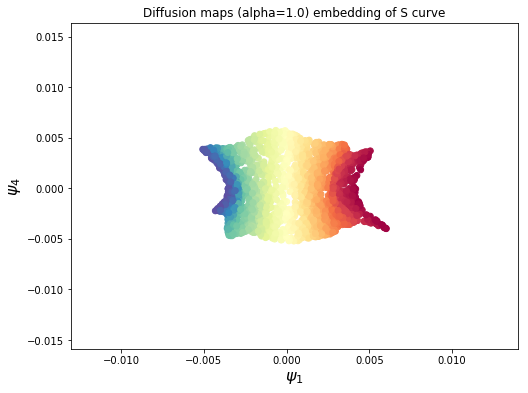

In [11]:
X_se = manifold.spectral_embedding(kernel, n_components = 2, eigen_solver = 'arpack')
plot_embedding(X_se, 'Diffusion maps (alpha=1.0) embedding of digits')

S_embedding = manifold.spectral_embedding(kernel_S, n_components=5, eigen_solver = 'arpack')
ax = plt.subplot(122);
plt.scatter(S_embedding[:,0],S_embedding[:,1], c=color, cmap=plt.cm.Spectral);
plt.title('Diffusion maps (alpha=1.0) embedding of S curve');
plt.xlabel('$\psi_1$',fontsize=16)
plt.ylabel('$\psi_2$',fontsize=16)
plt.axis('tight');

plt.figure(figsize=(8,6))
ax = plt.subplot(111);
plt.scatter(S_embedding[:,0],S_embedding[:,4], c=color, cmap=plt.cm.Spectral);
plt.title('Diffusion maps (alpha=1.0) embedding of S curve');
plt.axis('tight');
plt.xlabel('$\psi_1$',fontsize=16)
plt.ylabel('$\psi_4$',fontsize=16)